In [1]:
import config


from config import *

%matplotlib inline

2021-12-03 15:55:38.980360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#hard code now change later

path_accepts='/data02/AZC/AI_XRF/annotated_XRF/accept/bnp_fly0001_2018_1'
path_rejects='/data02/AZC/AI_XRF/annotated_XRF/reject/bnp_fly0001_2018_1'

# base_xrf_img_dir=os.path.split(fc.selected_path)[0]


#accepts
a_Cu=os.path.join(path_accepts,'Cu') + '/*.tif'
a_Zn=os.path.join(path_accepts,'Zn') + '/*.tif'
a_Ca=os.path.join(path_accepts,'Ca') + '/*.tif'
a_K=os.path.join(path_accepts,'K') + '/*.tif'
a_P=os.path.join(path_accepts,'P') + '/*.tif'
a_S=os.path.join(path_accepts,'S') + '/*.tif'
print(a_Cu)





#accepts
a_cells_Cu=sorted(glob.glob(a_Cu)) 
a_cells_Zn=sorted(glob.glob(a_Zn)) 
a_cells_Ca=sorted(glob.glob(a_Ca)) 
a_cells_K=sorted(glob.glob(a_K)) 
a_cells_P=sorted(glob.glob(a_P)) 
a_cells_S=sorted(glob.glob(a_S)) 

print('Count of accepts', len(a_cells_Cu))

#rejects
r_Cu=os.path.join(path_rejects,'Cu') + '/*.tif'
r_Zn=os.path.join(path_rejects,'Zn') + '/*.tif'
r_Ca=os.path.join(path_rejects,'Ca') + '/*.tif'
r_K=os.path.join(path_rejects,'K') + '/*.tif'
r_P=os.path.join(path_rejects,'P') + '/*.tif'
r_S=os.path.join(path_rejects,'S') + '/*.tif'
print(r_Cu)





#rejetcs
r_cells_Cu=sorted(glob.glob(r_Cu)) 
r_cells_Zn=sorted(glob.glob(r_Zn)) 
r_cells_Ca=sorted(glob.glob(r_Ca)) 
r_cells_K=sorted(glob.glob(r_K)) 
r_cells_P=sorted(glob.glob(r_P)) 
r_cells_S=sorted(glob.glob(r_S)) 

print('Count of rejectes', len(r_cells_Cu))


/data02/AZC/AI_XRF/annotated_XRF/accept/bnp_fly0001_2018_1/Cu/*.tif
Count of accepts 11
/data02/AZC/AI_XRF/annotated_XRF/reject/bnp_fly0001_2018_1/Cu/*.tif
Count of rejectes 11


In [3]:
#read all accept images in a single array for each channel
tiff_a_Cu=tiff.imread(a_cells_Cu)
tiff_a_Zn=tiff.imread(a_cells_Zn)
tiff_a_Ca=tiff.imread(a_cells_Ca)
tiff_a_K=tiff.imread(a_cells_K)
tiff_a_P=tiff.imread(a_cells_P)
tiff_a_S=tiff.imread(a_cells_S)



#read all reject images in a single array for each channel
tiff_r_Cu=tiff.imread(r_cells_Cu)
tiff_r_Zn=tiff.imread(r_cells_Zn)
tiff_r_Ca=tiff.imread(r_cells_Ca)
tiff_r_K=tiff.imread(r_cells_K)
tiff_r_P=tiff.imread(r_cells_P)
tiff_r_S=tiff.imread(r_cells_S)




In [4]:
#label accepts and rejects

y_accepts_Cu= np.ones(len(a_cells_Cu))
y_rejects_Cu= np.zeros(len(r_cells_Cu))

In [5]:
tiff_a_Cu.shape
# plt.imshow(tiff_a_Cu[0], interpolation='bicubic')

combined_ar_Cu=np.concatenate( (tiff_a_Cu, tiff_r_Cu) )
combined_labels_Cu=np.concatenate((y_accepts_Cu, y_rejects_Cu))

print(combined_ar_Cu.shape)
print(combined_labels_Cu.shape)


(22, 28, 28)
(22,)


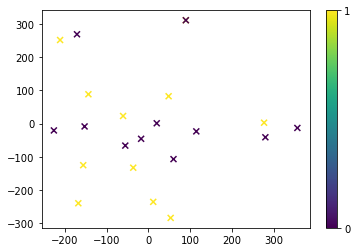

In [6]:
from openTSNE import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=3,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=False,
)

embeddings = tsne.fit(combined_ar_Cu.reshape(combined_ar_Cu.shape[0], combined_ar_Cu.shape[1]*combined_ar_Cu.shape[2]))



vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=combined_labels_Cu, marker='x')
plt.colorbar(ticks=range(2))
# plt.clim(-0.5, 9.5)
plt.show()


[0.14946811 0.12895848]
[0.00753489 0.00699886]


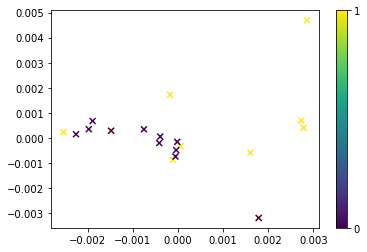

In [7]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca.fit(combined_ar_Cu.reshape(combined_ar_Cu.shape[0], combined_ar_Cu.shape[1]*combined_ar_Cu.shape[2]))

PCA_Outputs = pca.transform(combined_ar_Cu.reshape(combined_ar_Cu.shape[0], combined_ar_Cu.shape[1]*combined_ar_Cu.shape[2]))

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

vis_x = PCA_Outputs[:, 0]
vis_y = PCA_Outputs[:, 1]
plt.scatter(vis_x, vis_y, c=combined_labels_Cu, marker='x')
plt.colorbar(ticks=range(2))
#plt.clim(-0.5, 9.5)
plt.show()


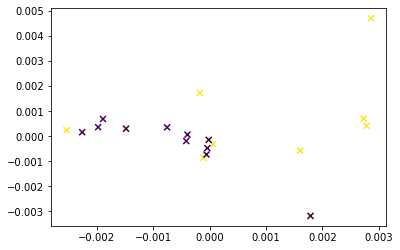

In [8]:
plt.scatter(vis_x, vis_y, c=combined_labels_Cu, marker='x')


In [9]:

df=pd.DataFrame(columns=['$z_0$', '$z_1$', '$z_2$','label'], data=np.concatenate([PCA_Outputs, combined_labels_Cu.reshape(-1,1)], axis=1 ))

plot_3Dprojection(df, figw = 5)
            

ValueError: Shape of passed values is (22, 3), indices imply (22, 4)

In [10]:
#Adding VAE

# INITIALIZERS

BASE_PATCH_WIDTH=28  #Width of the cell (pixels)

latent_dim=8

num_channels = 1

cell_types=2
noise_amplitude=0.000

from sklearn.model_selection import train_test_split

x_train, y_train, x_test, y_test= train_test_split(
    combined_ar_Cu, combined_labels_Cu, test_size=0.30, random_state=42)

x_train = x_train.astype('float32')
x_test= x_test.astype('float32')

#Allocate memory First
import tensorflow as tf
GPU_mem_limit=4.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])

    except RuntimeError as e:
        print(e)        
        
        
encoder,decoder=autoencoder(latent_dim,num_channels,BASE_PATCH_WIDTH,summary='yes')



vae = VAE(encoder, decoder,weight=1/20.0,regularization_type='kl',recon_type='bce')
vae.compile(optimizer='adam')
vae_plan_a=vae.fit(x_train, epochs=100, batch_size=4)  

model_history(vae_plan_a,'kl')

In [11]:
from sklearn.model_selection import train_test_split

x_train, y_train, x_test, y_test= train_test_split(
    combined_ar_Cu, combined_labels_Cu, test_size=0.30, random_state=42)

In [20]:
x_train = x_train.astype('float32')
x_test= x_test.astype('float32')

In [21]:

from ipywidgets import interactive
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def viewer(index):
    plt.figure(figsize=(5,5))
    plt.imshow(x_train[index])
    plt.colorbar(orientation='horizontal', shrink=0.8, location='top')
    plt.show()


interactive_image = interactive(viewer, index = (0,x_train.shape[0]-1))
output = interactive_image.children[-1]
# output.layout.height = '300px'
interactive_image

interactive(children=(IntSlider(value=7, description='index', max=14), Output()), _dom_classes=('widget-intera…

In [22]:
#Allocate memory First
import tensorflow as tf
GPU_mem_limit=4.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])

    except RuntimeError as e:
        print(e)        

In [23]:
encoder,decoder=autoencoder(latent_dim,num_channels,BASE_PATCH_WIDTH,summary='yes')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [24]:

vae = VAE(encoder, decoder,weight=1/20.0,regularization_type='kl',recon_type='bce')
vae.compile(optimizer='adam')
vae_plan_a=vae.fit(x_train, epochs=100, batch_size=4)  

Epoch 1/100


2021-12-03 15:58:56.266048: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: required broadcastable shapes at loc(unknown)
2021-12-03 15:58:56.266081: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: required broadcastable shapes at loc(unknown)
2021-12-03 15:58:56.266117: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: required broadcastable shapes at loc(unknown)
2021-12-03 15:58:56.266124: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: required broadcastable shapes at loc(unknown)


InvalidArgumentError:  required broadcastable shapes at loc(unknown)
	 [[node gradient_tape/truediv/RealDiv_1 (defined at ../tools/neural_nets/xrf_autoencoders.py:726) ]] [Op:__inference_train_function_3603]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/truediv/RealDiv_1:
 clip_by_value_2 (defined at ../tools/neural_nets/xrf_autoencoders.py:715)

Function call stack:
train_function


In [19]:
model_history(vae_plan_a,'kl')

NameError: name 'vae_plan_a' is not defined